In [1]:
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
#import stock_data_preprocessing
import datetime as dt
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
import seaborn as sns
import os
import datetime as dt
from pandas_datareader._utils import RemoteDataError
import bs4 as bs
import pickle
import requests
sns.set(palette='bright',style='whitegrid')
%matplotlib inline


warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    print ('yo')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in xrange(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

def load_data(filename, seq_len, normalise_window):
    f = open(filename, 'r').read()
    data = f.split('\n')

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in xrange(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in xrange(len(data)/prediction_len):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in xrange(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [9]:
def save_sp500_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'html.parser')
    table = soup.find('table',{'class':'wikitable sortable'})
    tickers =[]
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle","wb") as f:
              pickle.dump(tickers,f)
              
    #print(tickers)
              
    return tickers

def get_data_from_yahoo(reload_sp500=True,update_all=True):
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
        with open("sp500tickers.pickle","wb") as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    # define start date, end date , data table
    start = dt.datetime(1970,1,1)
    end   = dt.date.today()
    
    for ticker in tickers[:11]:
        print('{}\t: '.format(ticker), end="")
        if (not os.path.exists('stock_dfs/{}.csv'.format(ticker))) or update_all:
            try:
                df = web.DataReader(ticker, 'yahoo', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
                print('Succsess'.format(ticker))
            except RemoteDataError:
                print('ERROR'.format(ticker))
        else:
            print('Already have'.format(ticker))
            
#get_data_from_yahoo(reload_sp500=True,update_all=False)
#save_sp500_tickers()

def normalise_stock_data(data):


    # ADJ data
    data_adj=data
    
    #data_adj['Date'] = data.index.values+1
    for i in range(0,data.index.shape[0]):
        data_adj.loc[data.index[i],'Ordinal/1e6'] = data.index[i].to_pydatetime().toordinal()/1e6
        data_adj.loc[data.index[i],'Weekday']     = data.index[i].to_pydatetime().weekday()

    data_adj=data.drop(data.columns[[0,1,2,3,4,5]], axis=1)
    
    data_adj['Adj'] = data['Adj Close']/data['Close']
    
    data_adj['Adj Volume'] = data['Volume']
    #data_adj['Adj Volume'] -= np.min(data_adj['Adj Volume'])
    data_adj['Adj Volume'] /= np.max(data_adj['Adj Volume'])
    
    data_adj['Adj Close'] = data['Adj Close'] / data['Adj Close'][0] 
    data_adj['Adj Open'] = data['Open']*data_adj['Adj'] / data['Adj Close'][0] 
    data_adj['Adj High'] = data['High']*data_adj['Adj'] / data['Adj Close'][0] 
    data_adj['Adj Low']  = data['Low'] *data_adj['Adj'] / data['Adj Close'][0] 
    
    data_adj.loc[data.index[0],'Normalised Volume'] = 1
    data_adj.loc[data.index[1:],'Normalised Volume'] = data_adj['Adj Volume'][1:] / data_adj['Adj Close'][:-1].values
    data_adj.loc[data.index,'Normalised Volume'] -= 1

    data_adj.loc[data.index[0],'Normalised Close'] = 1
    data_adj.loc[data.index[1:],'Normalised Close'] = data_adj['Adj Close'][1:] / data_adj['Adj Close'][:-1].values
    data_adj.loc[data.index,'Normalised Close'] -= 1

    data_adj.loc[data.index[0],'Normalised Open'] = 1
    data_adj.loc[data.index[1:],'Normalised Open'] = data_adj['Adj Open'][1:] / data_adj['Adj Close'][:-1].values
    data_adj.loc[data.index,'Normalised Open'] -= 1

    data_adj.loc[data.index[0],'Normalised High'] = 1
    data_adj.loc[data.index[1:],'Normalised High'] = data_adj['Adj High'][1:] / data_adj['Adj Close'][:-1].values
    data_adj.loc[data.index,'Normalised High'] -= 1

    data_adj.loc[data.index[0],'Normalised Low'] = 1
    data_adj.loc[data.index[1:],'Normalised Low'] = data_adj['Adj Low'][1:] / data_adj['Adj Close'][:-1].values
    data_adj.loc[data.index,'Normalised Low'] -= 1

    #reduce some mean
    data_adj=data_adj.drop(['Adj'], axis=1)

    return data_adj


def stock_plot(data):

    #%matplotlib notebook
    #%matplotlib inline
    
    #plt.rcParams["figure.figsize"] = [16,16] 
    
    ax0 = plt.subplot2grid((6,2),(0,0),rowspan=5, colspan=1)
    ax1 = plt.subplot2grid((6,2),(5,0),rowspan=1, colspan=1, sharex=ax0)
    ax2 = plt.subplot2grid((6,2),(0,1),rowspan=5, colspan=1)
    ax3 = plt.subplot2grid((6,2),(5,1),rowspan=1, colspan=1, sharex=ax2)
    
    for each in data:
        ax0.plot(each.index,each['EURUSD'])
        ax1.plot(each.index,each['rsi_eurusd'])
        ax2.plot(each.index,each['oc_eurusd'])
        ax3.plot(each.index,each['hl_eurusd'])

    plt.show()
    
def single_batch(data_adj,pred_len=1):
    
    #print(data_adj.columns.values)
    #print(data_adj.dtypes)

    train_set_length = data_adj.shape[0]-(2*pred_len)+1
    train_set_width = data_adj.shape[1]

    train_X = np.empty([train_set_length,pred_len,train_set_width],dtype=data_adj.dtypes)
    train_Y = np.empty([train_set_length,pred_len,train_set_width],dtype=data_adj.dtypes) 

    for i in range(0, train_set_length):
        start = i
        end =   i + pred_len
        train_X[i] = data_adj.ix[start:end].as_matrix()
        train_Y[i] = data_adj.ix[start+pred_len:end+pred_len].as_matrix()
    
    return train_X,train_Y
    
#pd.DataFrame(data=data[1:,1:],    # values
#...              index=data[1:,0],    # 1st column as index
#...              columns=data[0,1:])  # 1st row as the column names
#train_X, train_Y = single_batch(data_n,pred_len=8)

def unroll(data,sequence_length=24):
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    return result

In [10]:
def get_stock_data(stock_name,data_source,start,end):
    df = web.DataReader(stock_name,data_source,start,end)
    #df.drop(df.columns[[1,3,4]], axis=1, inplace=True) 
    return df

In [11]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() #pd.DataFrame(stock)
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1][:,-1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    print('Amount of features :',amount_of_features)
    return [x_train, y_train, x_test, y_test]

In [20]:
df = pd.read_csv('eurusd.csv')
data_n = df.iloc[:,1:]

In [21]:
data_n.tail()

,oc_eurusd,hl_eurusd,eurusd_close,eurusd_Doc,eurusd_Dhl,rsi_eurusd,ema5_eurusd,ema21_eurusd,EURUSD
24456,-0.000345,0.001425,-0.002013,-1.960784,2.388889,1.873345,1.119404,1.119337,1.117915
24457,-0.000125,0.000690,0.000112,-0.897959,-0.481967,11.193971,1.118949,1.119219,1.118040
24458,0.000050,0.001415,-0.000045,-7.000000,0.917722,10.403430,1.118629,1.119107,1.117990
24459,-0.000840,0.000890,0.000751,-5.933333,-0.346535,73.436352,1.118696,1.119082,1.118830
24460,-0.000110,0.000555,0.000098,-0.986486,-0.338384,77.569319,1.118778,1.119069,1.118940


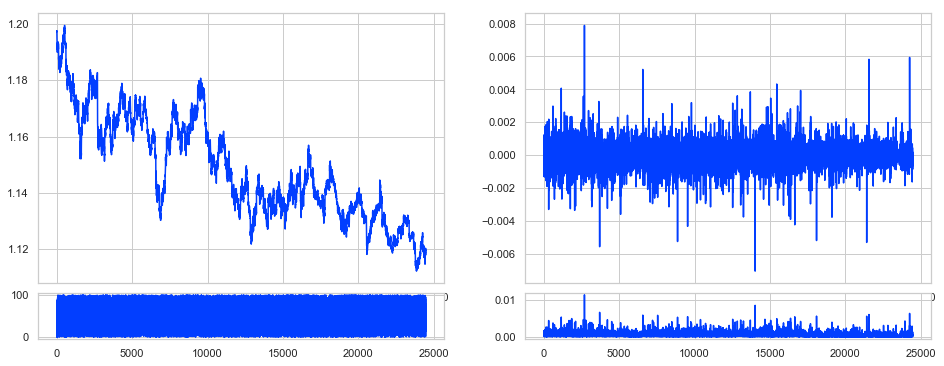

In [22]:
plt.figure(figsize = (16, 6))
stock_plot((data_n,))

In [23]:
window = 1
X_train, y_train, X_test, y_test = load_data(data_n[::-1], window)
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print("X_test", X_test.shape)
print("y_test", y_test.shape)

Amount of features : 9
X_train (22013, 1, 9)
y_train (22013,)
X_test (2446, 1, 9)
y_test (2446,)


def build_model(layers):
    model = Sequential()

    model.add(LSTM(
        input_dim=layers[0],
        output_dim=layers[1],
        return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
        output_dim=layers[2]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop",metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [24]:
def build_model2(layers):
        d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        model.add(Dropout(d))
        model.add(Dense(16,init='uniform',activation='relu'))        
        model.add(Dense(1,init='uniform',activation='relu'))
        model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
        return model

In [25]:
# model = build_model([3,lag,1])
model = build_model2([9,1,1])

In [26]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=500,
    validation_split=0.1)

Train on 19811 samples, validate on 2202 samples
Epoch 1/500
19811/19811 [==============================] - 7s 338us/step - loss: 0.9324 - acc: 0.0000e+00 - val_loss: 0.1273 - val_acc: 0.0000e+00
Epoch 2/500
19811/19811 [==============================] - 2s 81us/step - loss: 0.0492 - acc: 0.0000e+00 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 3/500
19811/19811 [==============================] - 2s 81us/step - loss: 0.0128 - acc: 0.0000e+00 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 4/500
19811/19811 [==============================] - 2s 83us/step - loss: 0.0086 - acc: 0.0000e+00 - val_loss: 0.0033 - val_acc: 0.0000e+00
Epoch 5/500
19811/19811 [==============================] - 2s 81us/step - loss: 0.0071 - acc: 0.0000e+00 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 6/500
19811/19811 [==============================] - 2s 81us/step - loss: 0.0062 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 7/500
19811/19811 [==============================] - 2s 83us/step - 

In [27]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))

Train Score: 0.00 MSE (0.01 RMSE)
Test Score: 0.00 MSE (0.02 RMSE)


In [28]:
# print(X_test[-1])
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))
    #print(u, y_test[u], pr, (y_test[u]/pr)-1, abs(y_test[u]- pr))

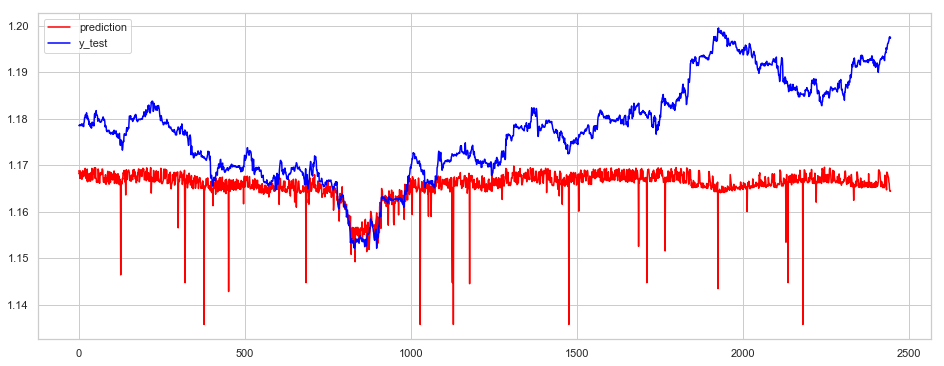

In [29]:
plt.figure(figsize = (16, 6))
plt.plot(p,color='red', label='prediction')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')